## Description 


During work over UNET improvement I decided to search for articles on its improvement. Original UNET doesn't use any residual connection, I thought that it is a possible room for improvement.
After that I've found an article about this idea, it's called DeepUNet:
https://arxiv.org/pdf/1709.00201.pdf

In our tasks we can't use this approach for increasing amount of layers of convolutions, but we can add more convolutions on every layer. Residual connections will deter gradient decay. In this notebook it slightly decreased quality.

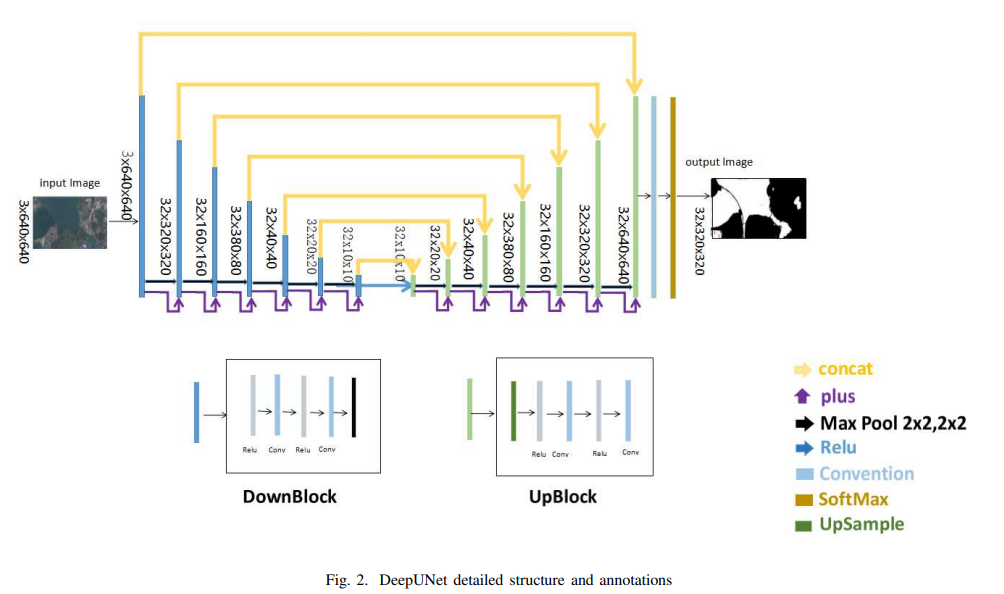

In [2]:
Image(filename = "DeepUNet.png", width=1000)

In [1]:
DATA_DIR = '/data/vapyzh/data'

In [2]:
ls $DATA_DIR

pred_valid_template.csv  test/  train/  train_mask/  valid/  valid_mask/


In [3]:
pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import cv2

import torch
import torchvision.transforms as transforms

from collections import defaultdict
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

from torch import nn
from torchsummary import summary

from PIL import Image
from torch.utils.data import Dataset, random_split
from lib import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [1]:
from IPython.display import Image

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, data_path, mask_path, transform):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
            transform: трансформация для изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path
        self.transform = transform

        self.file_list = os.listdir(self.data_path)
        self.mask_list = os.listdir(self.mask_path)

        #Теперь отсортируем их, чтобы получить соответсвие.

        self.file_list.sort()
        self.mask_list.sort()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_filename = self.file_list[idx]
        mask_filename = self.mask_list[idx]
        
        image = cv2.imread(os.path.join(self.data_path, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        mask = cv2.imread(os.path.join(self.mask_path, mask_filename))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"][:,:,0]
        mask[mask != 0] = 1

        return transformed["image"], mask

In [6]:
train_transformer = A.Compose(
    transforms = [
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(max_holes=2, max_height=26, max_width=26,
                                  min_height=20, min_width=20, mask_fill_value=0, p=0.3),
                  A.Perspective(scale=(0.05, 0.1), p=0.3),
                  A.RandomScale(scale_limit=0.1, p=0.3),
                  A.Rotate(limit=20, p=0.3, border_mode= cv2.BORDER_CONSTANT),
                  A.Resize(240, 320),
                  ToTensorV2(),
                  ],
)

validation_transformer = A.Compose(
    transforms = [
                  A.Resize(240, 320),
                  ToTensorV2(),
                  ],
)

In [7]:
dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)

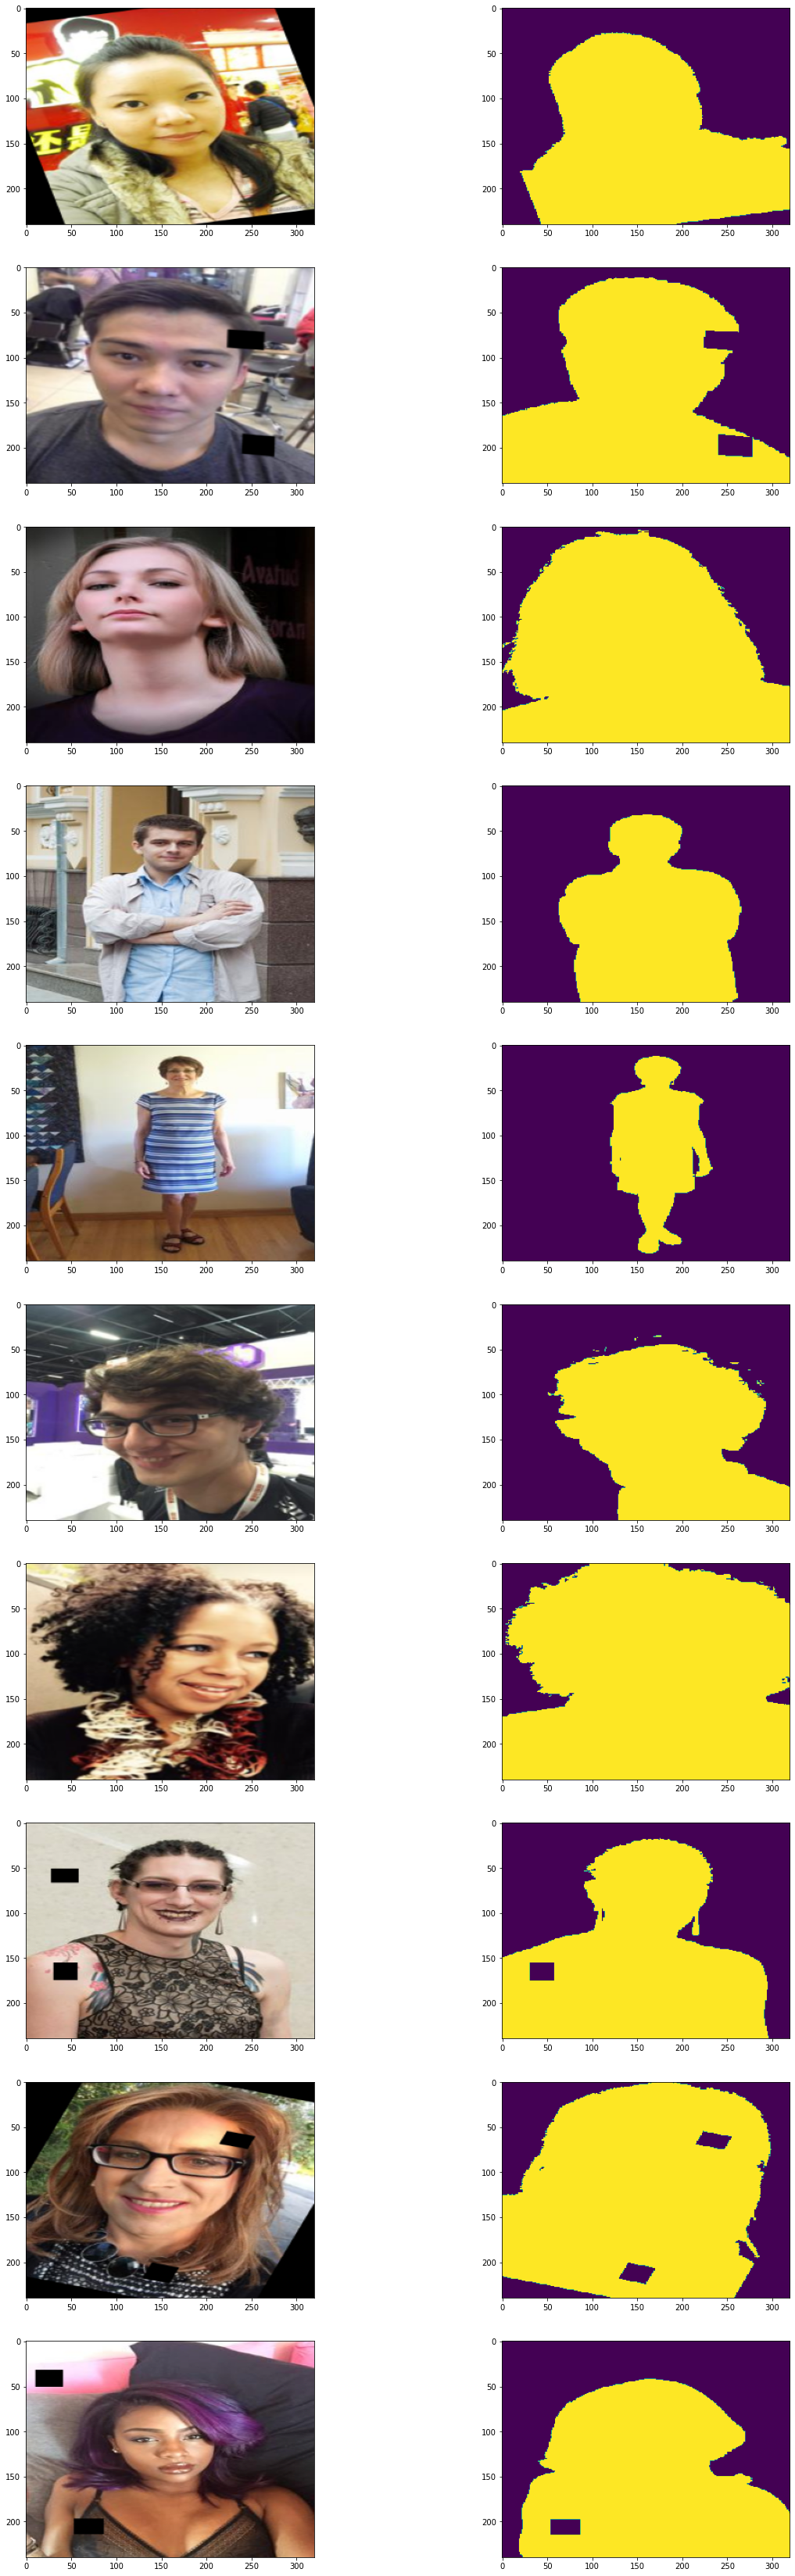

In [8]:
plt.figure(figsize=(20, 60))
for i in range(10):
    img, msk = dataset[i]
    plt.subplot(10, 2, i * 2 + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.subplot(10, 2, i * 2 + 2)
    plt.imshow(msk.squeeze())
plt.show()

In [15]:
class Downing_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )
  
  def forward(self, input_):
    return self.seq(input_)


class Uping_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )

  def forward(self, left, right):
    concated = torch.cat([left, right], dim=1)
    return self.seq(concated) 
    


class DeepUnet(nn.Module):
  def __init__(self):
    super().__init__()
    self.left1 = Downing_3x3_conv_lvl(3, 32)
    self.left1to2 = nn.MaxPool2d(2)

    self.left2 = Downing_3x3_conv_lvl(32, 32)
    self.left2to3 = nn.MaxPool2d(2)

    self.left3 = Downing_3x3_conv_lvl(32, 32)
    self.left3to4 = nn.MaxPool2d(2)

    self.left4 = Downing_3x3_conv_lvl(32, 32)
    self.left4to5 = nn.MaxPool2d(2)

    self.mid = Downing_3x3_conv_lvl(32, 32)
    
    self.right5to4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.right4 = Uping_3x3_conv_lvl(64, 32)

    self.right4to3 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.right3 = Uping_3x3_conv_lvl(64, 32)

    self.right3to2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.right2 = Uping_3x3_conv_lvl(64, 32)

    self.right2to1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.right1 = Uping_3x3_conv_lvl(64, 32)

    self.finish = nn.Conv2d(32, 2, kernel_size=1)
    

  def forward(self, input_):
    level1_cnv = self.left1(input_) # convolution
#     level1_cnv += input_ 
    level2_start = self.left1to2(level1_cnv) # maxPool

    level2_cnv = self.left2(level2_start) # convolution
    level2_cnv = level2_cnv + level2_start # residual 
    level3_start = self.left2to3(level2_cnv) #maxPool

    level3_cnv = self.left3(level3_start) # convolution
    level3_cnv = level3_cnv + level3_start # residual 
    level4_start = self.left3to4(level3_cnv)

    level4_cnv = self.left4(level4_start) #convolution
    level4_cnv = level4_cnv + level4_start # residual 
    level5_start = self.left4to5(level4_cnv)

    mid_res = self.mid(level5_start)

    right4_start = self.right5to4(mid_res) # UpSample
    right4_end = self.right4(level4_cnv, right4_start) # convolution
    right4_end = right4_end + right4_start # residual


    right3_start = self.right4to3(right4_end) #Up
    right3_end = self.right3(level3_cnv, right3_start) #conv
    right3_end = right3_end + right3_start # residual

    right2_start = self.right3to2(right3_end) #Up
    right2_end = self.right2(level2_cnv, right2_start) #conv
    right2_end = right2_end + right2_start # residual

    right1_start = self.right2to1(right2_end) #Up
    right1_end = self.right1(level1_cnv, right1_start) #conv
    right1_end = right1_end + right1_start # residual

    res = self.finish(right1_end)
    
    return res


In [16]:
device = f"cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model = DeepUnet().to(device)
summary(model, (3, 320, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 240]             864
              ReLU-2         [-1, 32, 320, 240]               0
            Conv2d-3         [-1, 32, 320, 240]           9,216
              ReLU-4         [-1, 32, 320, 240]               0
Downing_3x3_conv_lvl-5         [-1, 32, 320, 240]               0
         MaxPool2d-6         [-1, 32, 160, 120]               0
            Conv2d-7         [-1, 32, 160, 120]           9,216
              ReLU-8         [-1, 32, 160, 120]               0
            Conv2d-9         [-1, 32, 160, 120]           9,216
             ReLU-10         [-1, 32, 160, 120]               0
Downing_3x3_conv_lvl-11         [-1, 32, 160, 120]               0
        MaxPool2d-12           [-1, 32, 80, 60]               0
           Conv2d-13           [-1, 32, 80, 60]           9,216
             ReLU-14           [-1

In [18]:
def plot_learning_curves(history):
    '''
    Function for loss and metrics monitoring
    :param history: (dict)
    dice и loss on training and validation
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()


    plt.subplot(1,2,2)
    plt.title('dice', fontsize=15)
    plt.plot(history['dice']['train'], label='train')
    plt.plot(history['dice']['val'], label='val')
    plt.ylabel('dice', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.show()

In [19]:
train_dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)
validation_dataset = SegmentationDataset(DATA_DIR + '/valid', DATA_DIR + '/valid_mask', transform=validation_transformer)

In [20]:
batch_size = 12
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_batch_gen = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.85 ** epoch)

In [22]:
def train_with_aug(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    model_num,
    num_epochs=50,
):
    '''
    Pipeline for model training with monitoring loss and metrics.
    :param model: training model
    :param criterion: loss function
    :param optimizer: optimization method
    :param train_batch_gen: batch generator for process of training 
    :param val_batch_gen: batch generator for process of validation
    :param num_epochs: number of epochs
    :return: trained model
    :return: (dict) accuracy and dice on training and validation "history" of our training
    '''

    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_dice = 0
        
        val_loss = 0
        val_dice = 0
        
        start_time = time.time()

        model.train(True)

        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.squeeze().detach().cpu().numpy().argmax(axis=1)
            train_dice += get_dice(y_batch.cpu().numpy(), y_pred) 

        train_loss /= len(train_batch_gen)
        train_dice /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['dice']['train'].append(train_dice)

        scheduler.step()
        
        model.train(False)

        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.squeeze().detach().cpu().numpy().argmax(axis=1)
            val_dice += get_dice(y_batch.cpu().numpy(), y_pred)

        val_loss /= len(val_batch_gen)
        val_dice /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['dice']['val'].append(val_dice)


        clear_output()
        
        #beatiful print time and metrics
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training dice: \t\t\t{:.2f} %".format(train_dice * 100))
        print(" validation dice: \t\t\t{:.2f} %".format(val_dice * 100))
        
        plot_learning_curves(history)

        X_batch, y_batch = next(iter(val_batch_gen))
        orig = X_batch[0]
        true = y_batch[0]
        logits = model(orig.unsqueeze(0).float().to(device))
        pred = logits.detach().cpu().numpy()
        predicted_mask = pred.argmax(axis=1)

        plt.figure(figsize=(12, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(orig.permute(1, 2, 0), label="orig pic")
        plt.subplot(1, 3, 2)
        plt.imshow(true.squeeze(), label="true mask")
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[0], label="predicted mask")
        plt.show()


    return model, history   

Epoch 17 of 50 took 259.789s
 training loss (in-iteration): 	0.253768
 validation loss (in-iteration): 	0.262714
 training dice: 			91.27 %
 validation dice: 			90.38 %


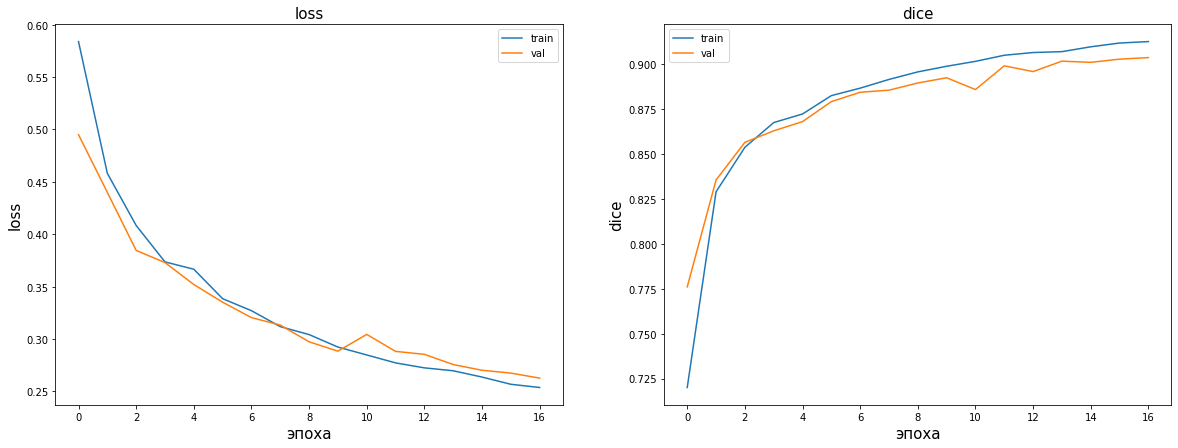

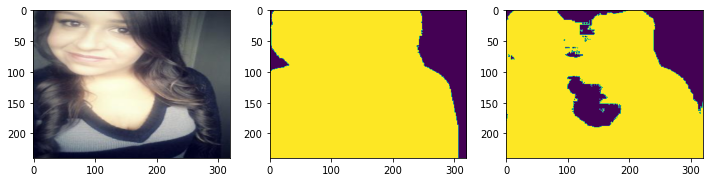

In [ ]:
model, history = train_with_aug(model,
                                criterion,
                                optimizer,
                                scheduler,
                                train_batch_gen,
                                val_batch_gen,
                                model_num=1,
                                num_epochs=50)

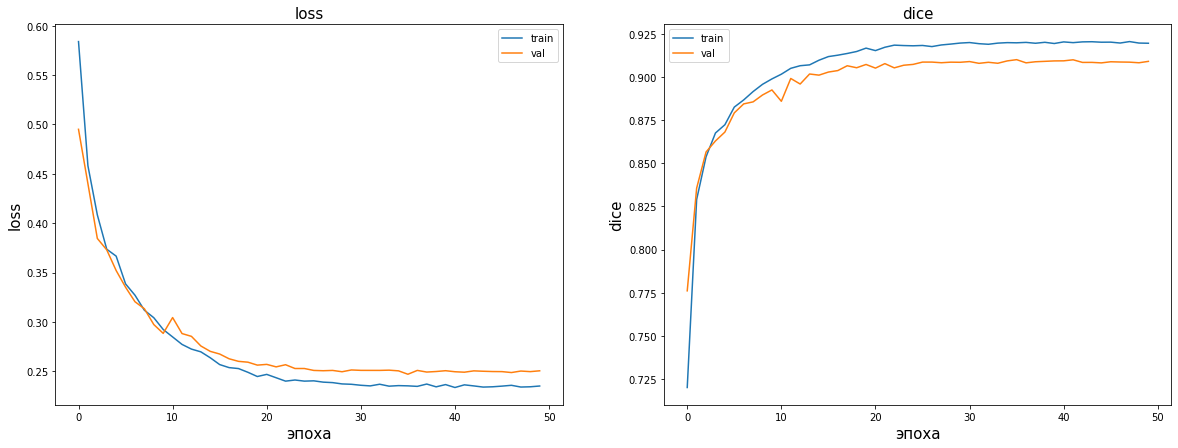

In [28]:
plot_learning_curves(history)

In [29]:
history["dice"]["val"]

[0.776049616806613,
 0.8355782748246026,
 0.8565517792913647,
 0.8629591737967216,
 0.8680947527897024,
 0.8792348027370059,
 0.8844374367713811,
 0.8856131893736557,
 0.8896015839286663,
 0.8925236551695369,
 0.885944633359435,
 0.8991722110250454,
 0.8959550054599523,
 0.9017703422005826,
 0.9011098695991547,
 0.9028921765577133,
 0.9037550967204879,
 0.9065480458365345,
 0.9053943307302662,
 0.9072938487870558,
 0.9051850247855765,
 0.9077849527420597,
 0.9053316816495363,
 0.9068495055401109,
 0.9073345367343757,
 0.9086733131849981,
 0.9086736835375425,
 0.9083023700762672,
 0.9086305229145765,
 0.9085611713719297,
 0.9089786218161519,
 0.907954278963166,
 0.9085590225052419,
 0.9079937935609673,
 0.9093593915121323,
 0.9100833926663979,
 0.9082405597105097,
 0.9088679999338299,
 0.9091086900158322,
 0.9093515135241916,
 0.9094006697830145,
 0.9100072510112645,
 0.908483671059576,
 0.9085028454935258,
 0.9082108089136662,
 0.9088620608015914,
 0.908716848359687,
 0.908634704279211